In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse import diags
from scipy.sparse.linalg import eigs
from scipy.interpolate import interp1d

## TASK A

In [2]:
h_bar = hbar = 1
mass = 1
tol = 1e-3

In [3]:
def numerov_algorithm(K, h, N):
    psi = np.zeros(N)
    psi[1] = h
    
    for i in range(1, N-1):
        w1 = 2 * (1 - (5 * h**2 / 12) * K[i])
        w2 = -(1 + (h**2 / 12) * K[i-1])
        w3 = (1 + (h**2 / 12) * K[i+1])
        psi[i+1] = (1 / w3) * (w1 * psi[i] + w2 * psi[i-1])
    
    norm = np.trapz(psi**2, dx=h)
    return psi / np.sqrt(norm)

In [ ]:
def potential_well(x, L):
    V = np.zeros_like(x)
    V[np.abs(x) > L] = np.inf
    return V

In [5]:
def infinite_TISE(L, Eo, N=500, hbar=h_bar, m=mass, num_states=4):
    x = np.linspace(0, L, N)
    h = L / (N - 1)
    V = potential_well(x, L)

    energies, wavefunctions, true_energies = [], [], []
    E1 = Eo

    for n in range(1, num_states + 1):
        E2 = E1 + 1 * n
        psi = numerov_algorithm((2 * m / hbar**2) * (E1 - V), h, N)
        psi_new = numerov_algorithm((2 * m / hbar**2) * (E2 - V), h, N)

        while psi[-1] * psi_new[-1] > 0:
            E1 += h
            E2 += h
            psi = numerov_algorithm((2 * m / hbar**2) * (E1 - V), h, N)
            psi_new = numerov_algorithm((2 * m / hbar**2) * (E2 - V), h, N)

        while True:
            E_mid = (E1 + E2) / 2
            psi_mid = numerov_algorithm((2 * m / hbar**2) * (E_mid - V), h, N)

            if abs(psi_mid[-1]) < tol:
                break
            E1, E2 = (E_mid, E2) if psi[-1] * psi_mid[-1] > 0 else (E1, E_mid)
            psi = psi_mid

        energies.append(E_mid)
        wavefunctions.append(psi_mid)
        true_energies.append(hbar**2 * np.pi**2 * n**2 / (2 * m * L**2))
        E1 = E2

    return wavefunctions, energies, true_energies

In [6]:
solution = infinite_TISE(L=2, Eo=0, N=601, num_states=4)

x = np.linspace(0, 2, 601)
xd = np.linspace(-1, 1, 601)

In [7]:
for i, (num_E, true_E) in enumerate(zip(solution[1], solution[2])):
    print(f'Numerical Energy E{i+1}: {num_E:.6f}')
    print(f'True Energy E{i+1}: {true_E:.6f}')
    print(f'Difference: {abs(num_E - true_E):.6f}\n')

Numerical Energy E1: 1.233737
True Energy E1: 1.233701
Difference: 0.000036

Numerical Energy E2: 4.934141
True Energy E2: 4.934802
Difference: 0.000662

Numerical Energy E3: 11.101784
True Energy E3: 11.103305
Difference: 0.001521

Numerical Energy E4: 19.737474
True Energy E4: 19.739209
Difference: 0.001735



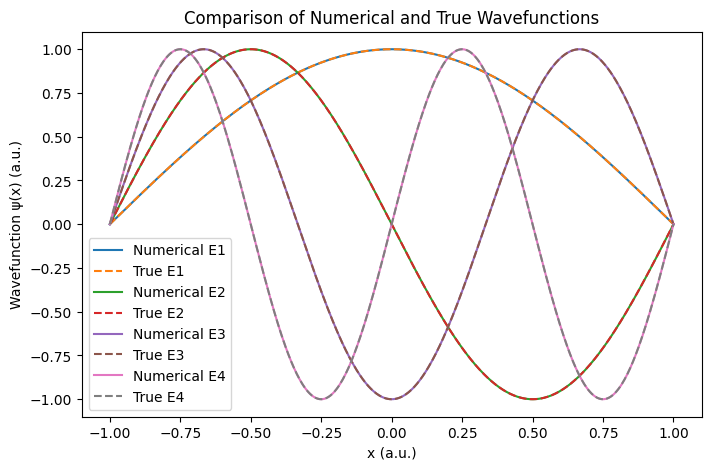

In [8]:
plt.figure(figsize=(8,5))

for i in range(len(solution[1])):
    plt.plot(xd, solution[0][i], label=f'Numerical E{i+1}')
    plt.plot(xd, np.sqrt(2/2) * np.sin(((i+1) * np.pi * x) / 2), linestyle='dashed', label=f'True E{i+1}')

plt.xlabel("x (a.u.)")
plt.ylabel("Wavefunction ψ(x) (a.u.)")
plt.title("Comparison of Numerical and True Wavefunctions")
plt.legend()
plt.show()

---

## TASK B

In [9]:
N = 1001

x_i, x_f = -4, 4
h = (x_f - x_i) / (N - 1)
x = np.linspace(x_i, x_f, N)

In [10]:
V0 = 10
V = np.where(np.abs(x) < 1, 0, V0)

In [11]:
def func(E): #Derivative continuity
    m = N // 4
    k = 2 * (E - V)

    yL, yR = np.zeros(N), np.zeros(N)
    yL[1], yR[N-2] = 1, 1

    for i in range(2, m+2):
        yL[i] = (2 * (1 - 5 * h**2 * k[i-1] / 12) * yL[i-1] - (1 + h**2 * k[i-2] / 12) * yL[i-2]) / (1 + h**2 * k[i] / 12) # Seems easier
        
        if abs(yL[i]) > 1e6:
            yL[:i+1] /= 1e6  

    for i in range(N-3, m-2, -1):
        yR[i] = (2 * (1 - 5 * h**2 * k[i+1] / 12) * yR[i+1] - (1 + h**2 * k[i+2] / 12) * yR[i+2]) / (1 + h**2 * k[i] / 12)
        
        if abs(yR[i]) > 1e6:
            yR[i:] /= 1e6  

    yL *= yR[m] / yL[m]

    return (yL[m] - yL[m-1]) - (yR[m+1] - yR[m])

In [12]:
def find_eigenvalue(e1, e2, tol=1e-6):
    while abs(func(e1)) > tol:
        e_mid = (e1 + e2) / 2
        if func(e_mid) * func(e1) > 0:
            e1 = e_mid
        else:
            e2 = e_mid
    return e1

In [13]:
energy_guesses = [(0.5, 2), (2, 4), (4, 7)]
eigenvalues = []

for e1, e2 in energy_guesses:
    E_sol = find_eigenvalue(e1, e2)
    if E_sol:
        eigenvalues.append(E_sol)

print("Found Eigenenergies:", eigenvalues)

Found Eigenenergies: [0.825051361694932, 3.241187572479248, 6.985241501737619]


In [14]:
def compute_wavefunction(e, V, h, N, m=N//4):
    yL, yR = np.zeros(N), np.zeros(N)
    k = 2 * (e - V)
    yL[1], yR[N - 2] = 1, 1
    
    for i in range(2, m + 2):
        yL[i] = (2 * (1 - 5 * h**2 * k[i - 1] / 12) * yL[i - 1] - (1 + h**2 * k[i - 2] / 12) * yL[i - 2]) / (1 + h**2 * k[i] / 12)
        if abs(yL[i]) > 1e6:
            yL[:i+1] /= 1e6
    
    for i in range(N - 3, m - 2, -1):
        yR[i] = (2 * (1 - 5 * h**2 * k[i + 1] / 12) * yR[i + 1] - (1 + h**2 * k[i + 2] / 12) * yR[i + 2]) / (1 + h**2 * k[i] / 12)
        if abs(yR[i]) > 1e6:
            yR[i:] /= 1e6
    
    yL *= yR[m] / yL[m]
    y = np.where(np.arange(N) <= m, yL, yR)
    norm = np.sqrt(np.sum(y**2) * h)
    
    return y / norm

In [15]:
wavefunctions = [compute_wavefunction(E, V, h, N) for E in eigenvalues]

In [16]:
eigenvalues_b = eigenvalues
eigenfunctions_b = wavefunctions

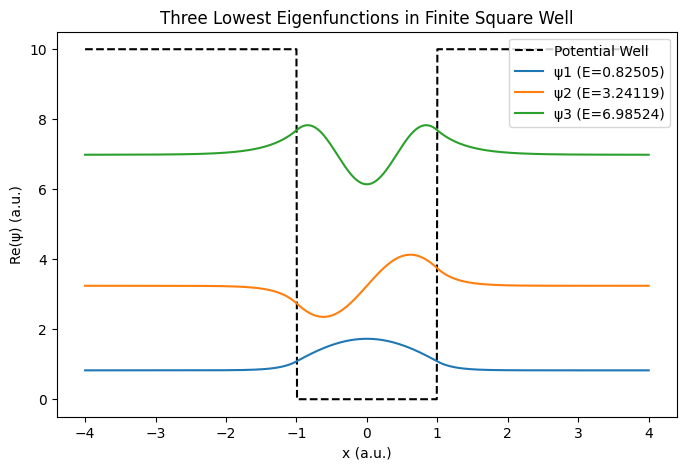

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(x, V, 'k--', label="Potential Well")
labels = ["ψ1","ψ2","ψ3"]

for i, (y, E, label) in enumerate(zip(wavefunctions, eigenvalues, labels)):
    plt.plot(x, y + E, label=f"{label} (E={E:.5f})")

plt.xlabel("x (a.u.)")
plt.ylabel("Re(ψ) (a.u.)")
plt.title("Three Lowest Eigenfunctions in Finite Square Well")
plt.legend(loc="upper right")
plt.show()

## (USING DISCRETIZATION)

In [18]:
diagonal = (hbar**2 / (mass * h**2)) + V
off_diagonal = -hbar**2 / (2 * mass * h**2)
H = diags([off_diagonal, diagonal, off_diagonal], [-1, 0, 1], shape=(N, N))

In [19]:
H_dense = H.toarray()
eigenvalues, eigenvectors = np.linalg.eigh(H_dense)

In [20]:
for i in range(len(eigenvalues)):
    psi = eigenvectors[:, i]
    norm = np.sqrt(np.trapz(psi**2, x))
    eigenvectors[:, i] = psi / norm

In [21]:
bound_states_mask = eigenvalues < V0
eigenvalues_bound = eigenvalues[bound_states_mask]
eigenfunctions_bound = eigenvectors[:, bound_states_mask]

In [22]:
eigenvalues_b_matrix = eigenvalues_bound
eigenfunctions_b_matrix = eigenfunctions_bound

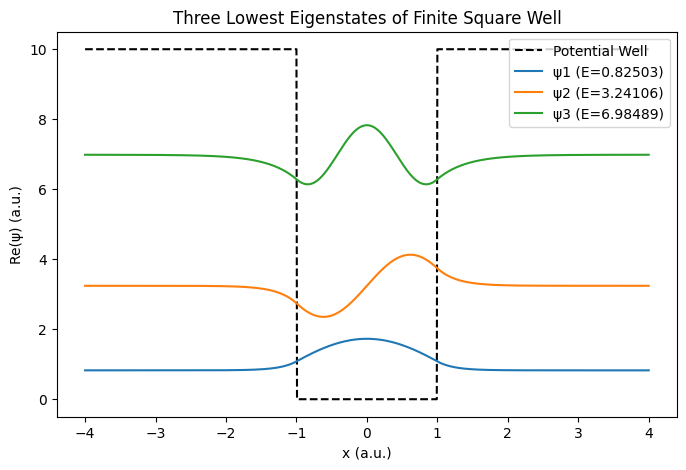

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(x, V, 'k--', label="Potential Well")
labels = ["ψ1", "ψ2", "ψ3"]

for i in range(3):
    plt.plot(x, eigenfunctions_bound[:, i] + eigenvalues_bound[i],
             label=f"{labels[i]} (E={eigenvalues_bound[i]:.5f})")

plt.xlabel("x (a.u.)")
plt.ylabel("Re(ψ) (a.u.)")
plt.title("Three Lowest Eigenstates of Finite Square Well")
plt.legend(loc="upper right")
plt.show()

In [24]:
eigenvalue_abs_diff = np.abs(eigenvalues_b_matrix - eigenvalues_b)
eigenvalue_rel_diff = eigenvalue_abs_diff / np.abs(eigenvalues_b)
mse_wavefunctions = np.mean((eigenfunctions_b_matrix.T - eigenfunctions_b) ** 2, axis=0)

print("Eigenvalue Absolute Difference:", eigenvalue_abs_diff)
print("Eigenvalue Relative Difference:", eigenvalue_rel_diff * 100, "%")
print("Mean Absolute Error (MAE):", np.mean(eigenvalue_abs_diff))
print("Mean Squared Error of Wavefunctions:", mse_wavefunctions)

Eigenvalue Absolute Difference: [2.02851683e-05 1.29087966e-04 3.47102591e-04]
Eigenvalue Relative Difference: [0.00245866 0.00398274 0.00496909] %
Mean Absolute Error (MAE): 0.00016549190839798555
Mean Squared Error of Wavefunctions: [9.64792673e-11 8.85544596e-10 2.47082061e-09 ... 2.45116380e-09
 8.79660940e-10 9.64792673e-11]


---

## TASK C

In [25]:
N = 2001

L = 2
D = 2.26
V0 = 0.87

x_i, x_f = -6, 6
h = (x_f - x_i) / (N - 1)
x = np.linspace(x_i, x_f, N)

In [26]:
def potential(x, L, D, V0):
    V = np.zeros_like(x)
    for i in range(len(x)):
        if (-L/2 - D/2 <= x[i] <= L/2 - D/2) or (-L/2 + D/2 <= x[i] <= L/2 + D/2):
            V[i] = -V0
        else:
            V[i] = 0
    return V

In [27]:
V = potential(x, L, D, V0)

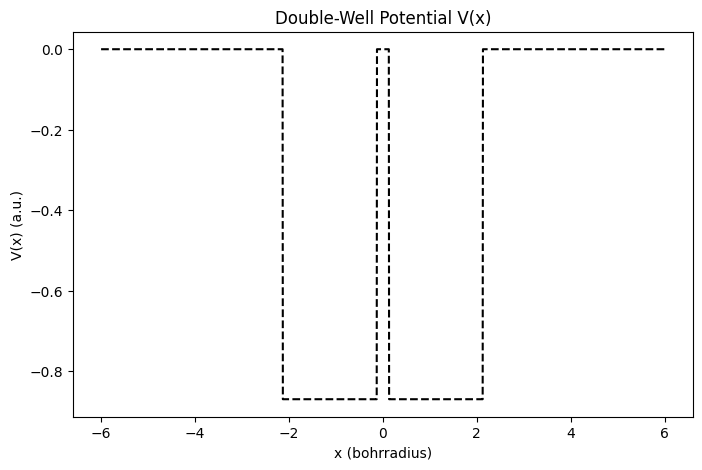

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(x, V, color='k', linestyle='dashed')
plt.title("Double-Well Potential V(x)")
plt.xlabel("x (bohrradius)")
plt.ylabel("V(x) (a.u.)")
plt.show()

Rewriting to better adjust for the following problems...

In [29]:
def func(e, V, h, N, m=N//4):
        yL, yR = np.zeros(N), np.zeros(N)
        k = 2 * (e - V)
        yL[1], yR[N - 2] = 1, 1

        for i in range(2, m + 2):
            yL[i] = (2 * (1 - 5 * h**2 * k[i - 1] / 12) * yL[i - 1] - (1 + h**2 * k[i - 2] / 12) * yL[i - 2]) / (1 + h**2 * k[i] / 12)
            if abs(yL[i]) > 1e6:
                yL[: i + 1] /= 1e6

        for i in range(N - 3, m - 2, -1):
            yR[i] = (2 * (1 - 5 * h**2 * k[i + 1] / 12) * yR[i + 1] - (1 + h**2 * k[i + 2] / 12) * yR[i + 2]) / (1 + h**2 * k[i] / 12)
            if abs(yR[i]) > 1e6:
                yR[i:] /= 1e6

        yL *= yR[m] / yL[m]
        return yL[m] - yL[m - 1] - (yR[m + 1] - yR[m])

In [30]:
def find_eigenvalue(e1, e2, V, h, N, tol=1e-6):
    while abs(func(e1, V, h, N)) > tol:
        e_mid = (e1 + e2) / 2
        if func(e_mid, V, h, N) * func(e1, V, h, N) > 0:
            e1 = e_mid
        else:
            e2 = e_mid
    return e1

Eigenvalue Energy: -0.499555


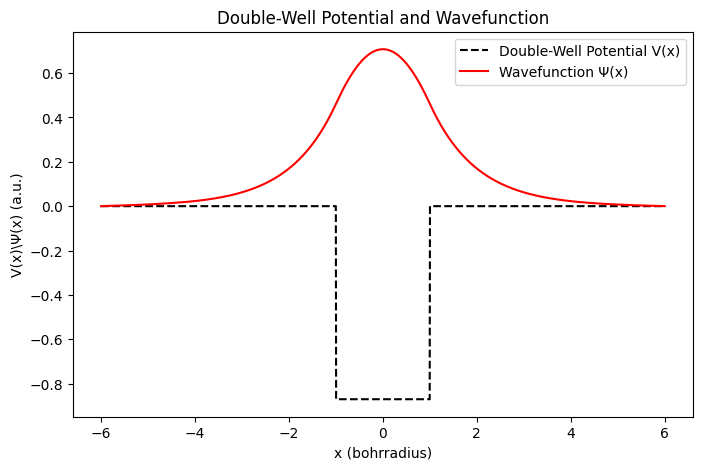

-------------------------------------------------------------------------------------------------
Eigenvalue Energy: -0.322673


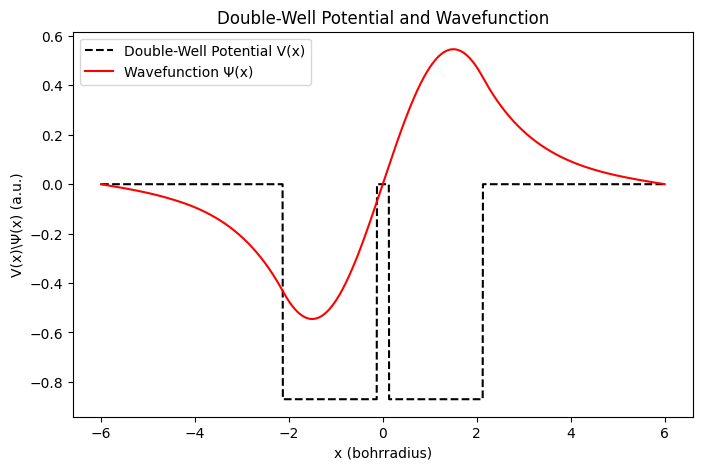

-------------------------------------------------------------------------------------------------
Eigenvalue Energy: -0.481223


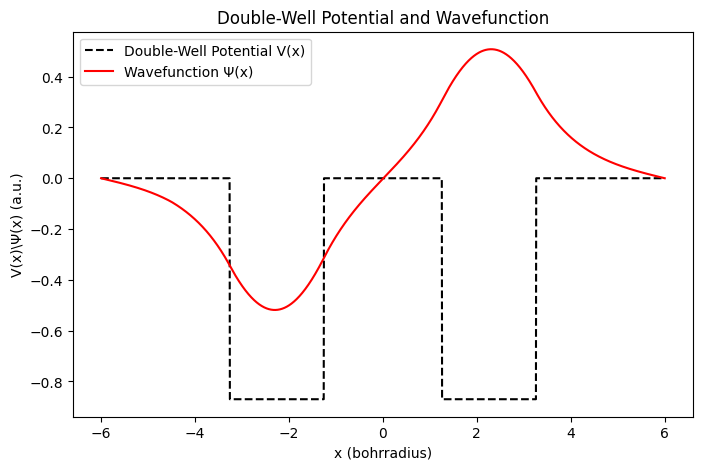

-------------------------------------------------------------------------------------------------


In [31]:
for i in range(3):
    N = 2001
    
    L = 2
    D = i * 2.26
    V0 = 0.87
    
    x_i, x_f = -6, 6
    h = (x_f - x_i) / (N - 1)
    x = np.linspace(x_i, x_f, N)
    
    V = potential(x, L, D, V0)
    
    # near -0.5
    e1, e2 = -0.1, -0.5
    eigen_energy = find_eigenvalue(e1, e2, V, h, N)
    print(f"Eigenvalue Energy: {eigen_energy:.6f}")
    
    wavefunction = compute_wavefunction(eigen_energy, V, h, N)
    
    plt.figure(figsize=(8, 5))
    plt.plot(x, V, label="Double-Well Potential V(x)", color='k', linestyle='dashed')
    plt.plot(x, wavefunction, label="Wavefunction Ψ(x)", color='r')
    
    plt.title("Double-Well Potential and Wavefunction")
    plt.xlabel("x (bohrradius)")
    plt.ylabel("V(x)\Ψ(x) (a.u.)")
    plt.legend()
    plt.show()

    print(f"-------------------------------------------------------------------------------------------------")

D = 2.26, Ground State Energy: -0.322673, First Excited State Energy: -0.657111


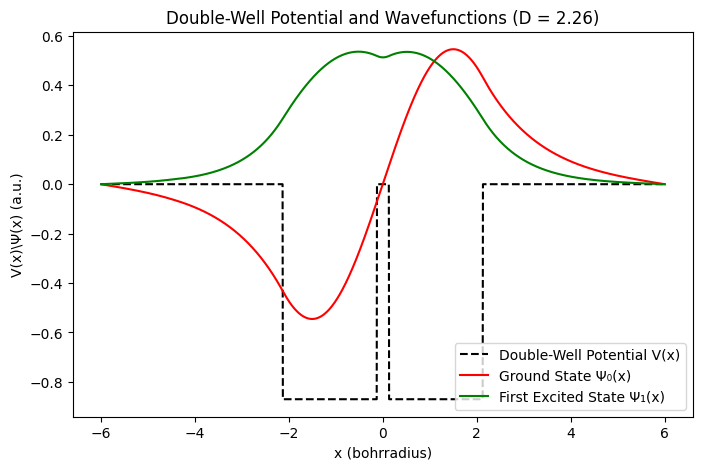

-------------------------------------------------------------------------------------------------
D = 4.52, Ground State Energy: -0.481223, First Excited State Energy: -0.516042


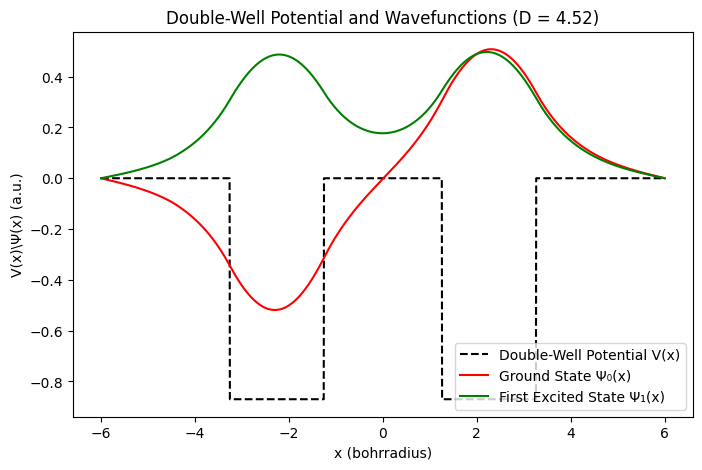

-------------------------------------------------------------------------------------------------


In [32]:
for i in range(1,3):
    N = 2001
    
    L = 2
    D = i * 2.26
    V0 = 0.87
    
    x_i, x_f = -6, 6
    h = (x_f - x_i) / (N - 1)
    x = np.linspace(x_i, x_f, N)
    
    V = potential(x, L, D, V0)

    e1, e2 = -0.1, -0.5
    E0 = find_eigenvalue(e1, e2, V, h, N, tol=1e-6)
    
    e1, e2 = -0.5, -1.0
    E1 = find_eigenvalue(e1, e2, V, h, N, tol=1e-6)
    
    print(f"D = {D:.2f}, Ground State Energy: {E0:.6f}, First Excited State Energy: {E1:.6f}")
    
    psi0 = compute_wavefunction(E0, V, h, N)
    psi1 = compute_wavefunction(E1, V, h, N)
    
    plt.figure(figsize=(8, 5))
    plt.plot(x, V, label="Double-Well Potential V(x)", color='k', linestyle='dashed')
    plt.plot(x, psi0, label="Ground State Ψ₀(x)", color='r')
    plt.plot(x, psi1, label="First Excited State Ψ₁(x)", color='g')
    
    plt.title(f"Double-Well Potential and Wavefunctions (D = {D:.2f})")
    plt.xlabel("x (bohrradius)")
    plt.ylabel("V(x)\Ψ(x) (a.u.)")
    plt.legend(loc="lower right")
    plt.show()

    print(f"-------------------------------------------------------------------------------------------------")

I devised a method to store the eigenvalues of the energy for various values of the distance. However, the cell kept running endlessly...

In [33]:
results_e1 = []
results_e2 = []
d_all = []

i = 1
increment = 0.25
timeout = 3 # Don't change it becomes unstable
timeout_start = time.time()

while time.time() - timeout_start < timeout:
    N = 2001
    
    L = 2
    D = i * 2.26
    V0 = 0.87
    
    x_i, x_f = -6, 6
    h = (x_f - x_i) / (N - 1)
    x = np.linspace(x_i, x_f, N)

    V = potential(x, L, D, V0)

    e1, e2 = -0.1, -0.5
    E0 = find_eigenvalue(e1, e2, V, h, N, tol=1e-6)

    e1, e2 = -0.5, -1.0
    E1 = find_eigenvalue(e1, e2, V, h, N, tol=1e-6)

    results_e1.append(E0)
    results_e2.append(E1)
    d_all.append(D)

    i += increment

print("Timeout")

KeyboardInterrupt: 

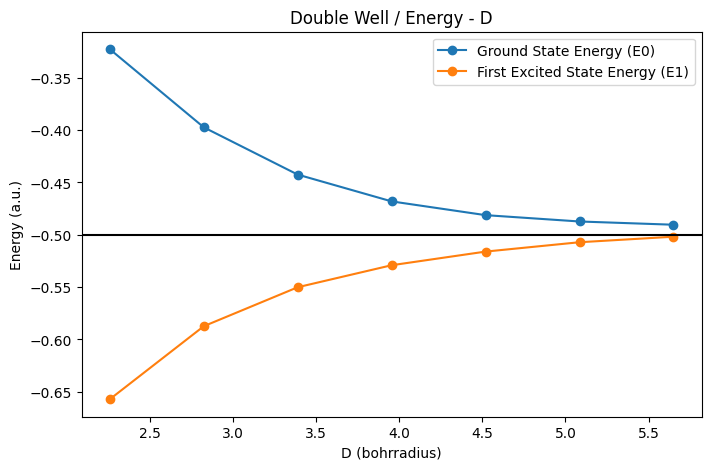

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(d_all, results_e1, marker='o', linestyle='-', label='Ground State Energy (E0)')
plt.plot(d_all, results_e2, marker='o', linestyle='-', label='First Excited State Energy (E1)')
plt.axhline(y = -0.5, color = 'k', linestyle = '-') 

plt.xlabel("D (bohrradius)")
plt.ylabel("Energy (a.u.)")
plt.title("Double Well / Energy - D")
plt.legend()

plt.show()

---

## TASK D

In [35]:
N = 2001

x_min, x_max = -4, 4
h = (x_max - x_min) / (N - 1)
x = np.linspace(x_min, x_max, N)

V = 0.5 * x**2

In [36]:
eigenvalues = []
eigenfunctions = []
energy_ranges = [(0, 1), (1, 2), (2, 3)]

for E1, E2 in energy_ranges:
    eigenvalue = find_eigenvalue(E1, E2, V, h, N)
    eigenvalues.append(eigenvalue)
    eigenfunctions.append(compute_wavefunction(eigenvalue, V, h, N))

In [37]:
for i, E in enumerate(eigenvalues):
    print(f"Eigenvalue {i + 1}: {E:.6f}")

Eigenvalue 1: 0.499938
Eigenvalue 2: 1.499849
Eigenvalue 3: 2.500708


In [38]:
eigenvalues_d = eigenvalues
eigenfunctions_d = eigenfunctions

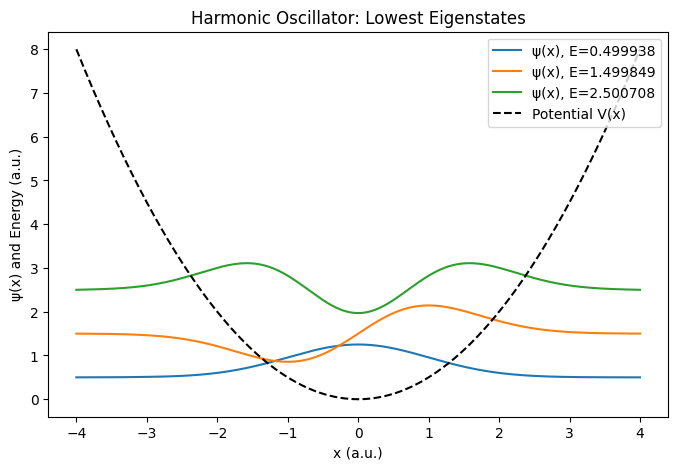

In [39]:
plt.figure(figsize=(8, 5))

for i, wavefunction in enumerate(eigenfunctions):
    plt.plot(x, wavefunction + eigenvalues[i], label=f"ψ(x), E={eigenvalues[i]:.6f}")

plt.plot(x, V, label="Potential V(x)", linestyle="--", color="black")
plt.title("Harmonic Oscillator: Lowest Eigenstates")
plt.xlabel("x (a.u.)")
plt.ylabel("ψ(x) and Energy (a.u.)")
plt.legend(loc="upper right")
plt.show()

## (USING DISCRETIZATION)

In [40]:
diagonal = (hbar**2 / (mass * h**2)) + V
off_diagonal = -hbar**2 / (2 * mass * h**2)
H = diags([off_diagonal, diagonal, off_diagonal], [-1, 0, 1], shape=(N, N))

In [41]:
H_dense = H.toarray()
eigenvalues, eigenvectors = np.linalg.eigh(H_dense)

In [42]:
num_states = 3
eigenvalues = eigenvalues[:num_states]
eigenfunctions = eigenvectors[:, :num_states]

In [43]:
for i in range(num_states):
    norm = np.sqrt(np.trapz(eigenfunctions[:, i]**2, x))
    eigenfunctions[:, i] /= norm

In [44]:
for i in range(num_states):
    max_index = np.argmax(np.abs(eigenfunctions[:, i]))
    if eigenfunctions[max_index, i] < 0:
        eigenfunctions[:, i] *= -1

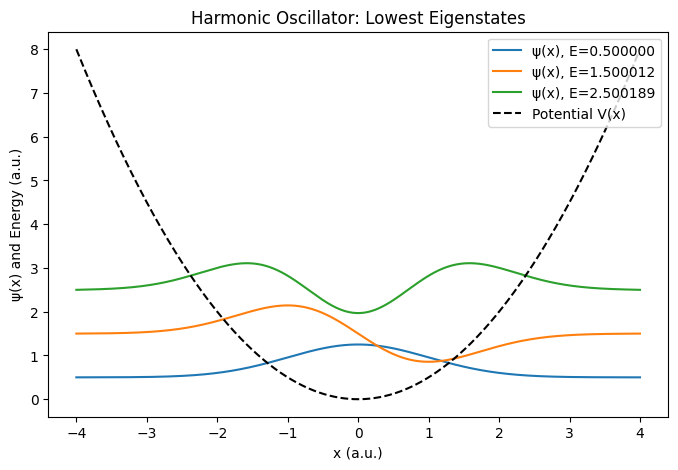

In [45]:
plt.figure(figsize=(8, 5))

for i, wavefunction in enumerate(eigenfunctions.T):
    plt.plot(x, wavefunction + eigenvalues[i], label=f"ψ(x), E={eigenvalues[i]:.6f}")

plt.plot(x, V, label="Potential V(x)", linestyle="--", color="black")
plt.title("Harmonic Oscillator: Lowest Eigenstates")
plt.xlabel("x (a.u.)")
plt.ylabel("ψ(x) and Energy (a.u.)")
plt.legend(loc="upper right")
plt.show()

In [46]:
eigenvalues_d_matrix = eigenvalues
eigenfunctions_d_matrix = wavefunction

In [47]:
eigenvalue_abs_diff = np.abs(eigenvalues_d_matrix - eigenvalues_d)
eigenvalue_rel_diff = eigenvalue_abs_diff / np.abs(eigenvalues_d)
mse_wavefunctions = np.mean((eigenfunctions_d_matrix - eigenfunctions_d) ** 2, axis=0)

print("Eigenvalue Absolute Difference:", eigenvalue_abs_diff)
print("Eigenvalue Relative Difference:", eigenvalue_rel_diff * 100, "%")
print("Mean Absolute Error (MAE):", np.mean(eigenvalue_abs_diff))
print("Mean Squared Error of Wavefunctions:", mse_wavefunctions)

Eigenvalue Absolute Difference: [6.17007333e-05 1.62686615e-04 5.18207747e-04]
Eigenvalue Relative Difference: [0.01234167 0.01084687 0.02072244] %
Mean Absolute Error (MAE): 0.00024753169850960655
Mean Squared Error of Wavefunctions: [2.07048941e-08 6.92896765e-08 1.53169302e-07 ... 1.05074488e-07
 5.31656542e-08 2.07048941e-08]


---

## TASK E

In [48]:
Z = 1
l = 0
N = 15001

r0 = 1e-6 # Avoid singularity
rmax = 40
h = (rmax - r0) / (N - 1)
r = np.linspace(rmax, r0, N)[::-1]

In [49]:
def V(r):
    return l * (l + 1) / r**2 - 2 * Z / r

In [50]:
def new_numerov(E):
    u = np.zeros(N)
    k = E - V(r)
    u[-1] = 1e-6  # Boundary condition , rmax
    u[-2] = 1e-6 * (1 - h**2 * k[-1] / 12)  # Second point: Taylor expansion

    for i in range(N - 3, -1, -1): # Only backward!
        u[i] = (2 * (1 - 5 * h**2 * k[i + 1] / 12) * u[i + 1] - (1 + h**2 * k[i + 2] / 12) * u[i + 2]) / (1 + h**2 * k[i] / 12)
    return u

In [51]:
def boundary_condition(E):
    u = new_numerov(E)
    return u[0] - u[1] - (u[1] - u[0]) / h * r0  # Boundary condition, r=0

In [52]:
def new_shooting(E1, E2, tol=1e-6):
    while abs(E2 - E1) > tol:
        E_mid = (E1 + E2) / 2
        if boundary_condition(E_mid) * boundary_condition(E1) > 0:
            E1 = E_mid
        else:
            E2 = E_mid
    return (E1 + E2) / 2

In [53]:
eigenvalues = []
eigenfunctions = []
energy_ranges = [(-1.5, -1), (-0.5, -0.2), (-0.2, -0.10)] 

In [54]:
for E1, E2 in energy_ranges:
    E = new_shooting(E1, E2)
    eigenvalues.append(E)
    eigenfunctions.append(new_numerov(E))

In [55]:
for i in range(len(eigenfunctions)):
    norm = np.trapz(eigenfunctions[i]**2, r)
    eigenfunctions[i] /= np.sqrt(norm)

In [56]:
for i, E in enumerate(eigenvalues):
    print(f"Eigenvalue {i + 1}: {E:.6f}")

Eigenvalue 1: -1.000000
Eigenvalue 2: -0.247677
Eigenvalue 3: -0.110424


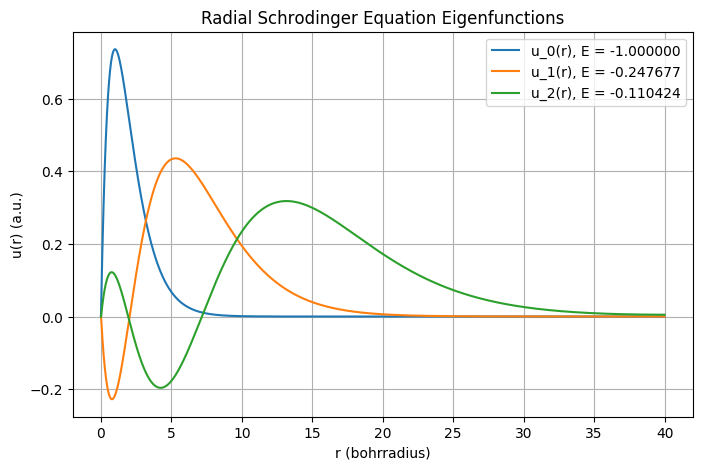

In [57]:
plt.figure(figsize=(8, 5))

for i, u in enumerate(eigenfunctions):
    plt.plot(r, u, label=f"u_{i}(r), E = {eigenvalues[i]:.6f}")
    
plt.xlabel("r (bohrradius)")
plt.ylabel("u(r) (a.u.)")
plt.title("Radial Schrοdinger Equation Eigenfunctions")
plt.legend()
plt.grid()
plt.show()

---

## IMPACT OF MESH SIZE (USING DISCRETIZATION)

In [58]:
hbar = 1.0
mass = 1.0
V0 = 0.87
L = 2.0
omega = 1.0
x_i, x_f = -6, 6
num_states = 3

In [59]:
def finite_well_potential(x, L, V0):
    return np.where(np.abs(x) > L, V0, 0)

def quantum_oscillator_potential(x, omega, mass):
    return 0.5 * mass * omega**2 * x**2

In [60]:
N_values = np.arange(500, 6000, 500)
N_ref = max(N_values)
h_ref = (x_f - x_i) / (N_ref - 1)
x_ref = np.linspace(x_i, x_f, N_ref)

V_ref = finite_well_potential(x_ref, L, V0)
#V_ref = quantum_oscillator_potential(x_ref, omega, mass) #<- Uncomment to use!!

diagonal_ref = (hbar**2 / (mass * h_ref**2)) + V_ref
off_diagonal_ref = -hbar**2 / (2 * mass * h_ref**2)
H_ref = diags([off_diagonal_ref, diagonal_ref, off_diagonal_ref], [-1, 0, 1], shape=(N_ref, N_ref)).toarray()
eigenvalues_ref, eigenvectors_ref = np.linalg.eigh(H_ref)

In [61]:
for i in range(len(eigenvalues_ref)):
    psi = eigenvectors_ref[:, i]
    norm = np.sqrt(np.trapz(psi**2, x_ref))
    eigenvectors_ref[:, i] = psi / norm

In [62]:
bound_states_mask_ref = eigenvalues_ref < np.max(V_ref)
eigenvalues_ref = eigenvalues_ref[bound_states_mask_ref][:num_states]
eigenfunctions_ref = eigenvectors_ref[:, bound_states_mask_ref][:, :num_states]

In [63]:
mse_values = []
rel_diff_values = []
runtime = []

In [64]:
for N in N_values:
    start_time = time.time()

    h = (x_f - x_i) / (N - 1)
    x = np.linspace(x_i, x_f, N)

    V = finite_well_potential(x, L, V0)
    #V = quantum_oscillator_potential(x, omega, mass) #<- Uncomment to use!!

    diagonal = (hbar**2 / (mass * h**2)) + V
    off_diagonal = -hbar**2 / (2 * mass * h**2)
    H = diags([off_diagonal, diagonal, off_diagonal], [-1, 0, 1], shape=(N, N)).toarray()
    
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    for i in range(len(eigenvalues)):
        psi = eigenvectors[:, i]
        norm = np.sqrt(np.trapz(psi**2, x))
        eigenvectors[:, i] = psi / norm

    bound_states_mask = eigenvalues < np.max(V)
    eigenvalues = eigenvalues[bound_states_mask][:num_states]
    eigenfunctions = eigenvectors[:, bound_states_mask][:, :num_states]

    interpolate_func = interp1d(x_ref, eigenfunctions_ref, axis=0, kind='linear', fill_value='extrapolate')
    eigenfunctions_ref_interp = interpolate_func(x)

    mse_wavefunctions = np.mean((eigenfunctions_ref_interp - eigenfunctions) ** 2, axis=0)

    eigenvalue_abs_diff = np.abs(eigenvalues_ref - eigenvalues)
    eigenvalue_rel_diff = eigenvalue_abs_diff / np.abs(eigenvalues_ref) * 100

    mse_values.append(np.mean(mse_wavefunctions))
    rel_diff_values.append(np.mean(eigenvalue_rel_diff))

    runtime.append(time.time() - start_time)

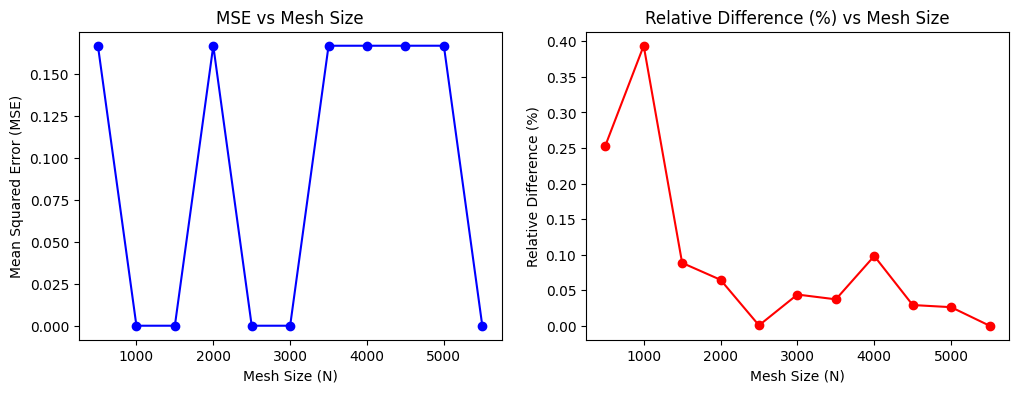

In [65]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(N_values, mse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Mesh Size (N)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Mesh Size')

plt.subplot(1, 2, 2)
plt.plot(N_values, rel_diff_values, marker='o', linestyle='-', color='r')
plt.xlabel('Mesh Size (N)')
plt.ylabel('Relative Difference (%)')
plt.title('Relative Difference (%) vs Mesh Size')
plt.show()

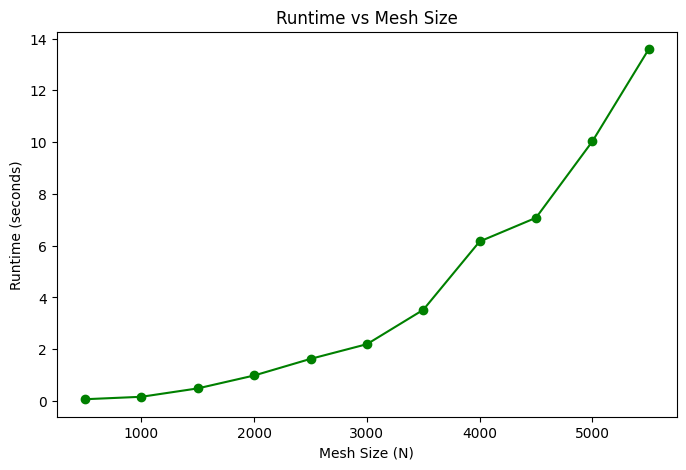

In [66]:
plt.figure(figsize=(8, 5))
plt.plot(N_values, runtime, marker='o', linestyle='-', color='g')
plt.xlabel('Mesh Size (N)')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs Mesh Size')
plt.show()